In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

Load MNIST FASHION DATA

In [3]:
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


MNIST CLASSES

In [4]:
classes =['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
          'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot' ]

Visualise few images and labels

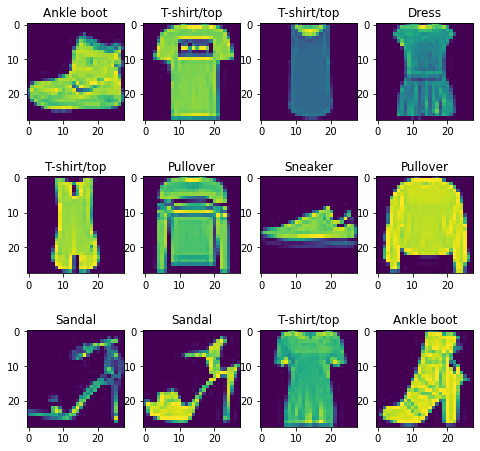

In [5]:
fig=plt.figure(figsize=(8, 8))
row = 3; col = 4
for i in range(row*col):
  fig.add_subplot(row, col, i+1).set_title(str(classes[training_labels[i]]))
  plt.imshow(training_images[i])
plt.show()

Normalize the images dataset 

In [6]:
training_images, test_images = training_images/255.0, test_images/255.0

Define Neural Network for MNIST Fashion data

In [7]:
def get_NN_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
  model.add(tf.keras.layers.Dense(256, activation= 'relu'))
  model.add(tf.keras.layers.Dense(256, activation= 'relu'))
  model.add(tf.keras.layers.Dense(10, activation= 'softmax'))
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

Define convolutional network for MNIST Fashion data

In [8]:
def get_CNN_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(64,(3,3), input_shape=(28,28,1), padding = 'same', activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D((2,2)))
  model.add(tf.keras.layers.Conv2D(128,(3,3), padding = 'same', activation = 'relu'))
  model.add(tf.keras.layers.MaxPooling2D((2,2)))
  model.add(tf.keras.layers.Conv2D(128,(3,3), padding = 'same', activation = 'relu'))
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  # model.add(tf.keras.layers.Flatten())
  # model.add(tf.keras.layers.Dense(256, activation = 'relu'))
  model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model


Callback to stop trainig after reaching 99% accuracy

In [9]:
class epoch_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.99):
      self.model.stop_training = True

Create NN and CNN model

In [10]:
nn_model = get_NN_model()
print(nn_model.summary())
cnn_model = get_CNN_model()
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_______________________

Train NN model for 30 epochs

In [ ]:
filepath = '/content/nn_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss',
                                                save_best_only=True,mode = 'auto')
callback = epoch_callback()

history_nn = nn_model.fit(
    training_images, training_labels, 
    validation_data=(test_images, test_labels), 
    epochs=30, 
    callbacks=[checkpoint,callback])

Change image dimension for cnn network training. CNN requires (None, W, H, C) dimension.

In [ ]:
training_images_cnn = np.expand_dims(training_images, axis=3)
test_images_cnn = np.expand_dims(test_images, axis=3)
print(training_images_cnn.shape, test_images_cnn.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


Train CNN for 30 epochs

In [ ]:
filepath = '/content/cnn_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',
                                                save_best_only=True, mode = 'auto')
callback = epoch_callback()

history_cnn = cnn_model.fit(
    training_images_cnn, 
    training_labels, 
    validation_data=(test_images_cnn, test_labels),
    epochs=30, 
    callbacks = [checkpoint,callback])

Plot Training and Validation loss graph for NN and CNN

In [ ]:
def plot_model_history(history, title):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

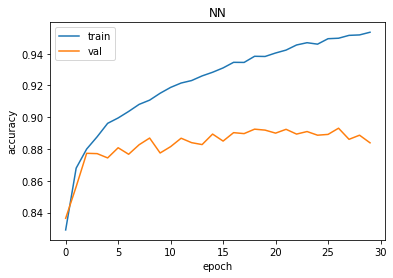

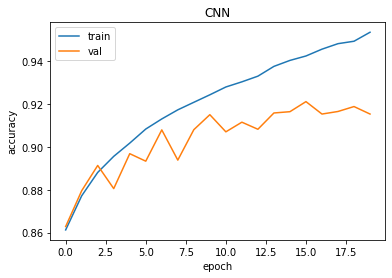

In [ ]:
plot_model_history(history_nn, 'NN')
plot_model_history(history_cnn, 'CNN')

In [ ]:
nn_model.load_weights('/content/nn_model.h5')
cnn_model.load_weights('/content/cnn_model.h5')

In [ ]:
evaluation_nn = nn_model.evaluate(test_images, test_labels)
evaluation_cnn = cnn_model.evaluate(test_images_cnn, test_labels)

print('NN loss : ', evaluation_nn[0], ' accuracy: ', evaluation_nn[1], 'on test data.')
print('CNN loss : ', evaluation_cnn[0], ' accuracy: ', evaluation_cnn[1], 'on test data.')

313/313 [==============================] - 1s 2ms/step - loss: 0.2258 - accuracy: 0.9212
NN loss :  0.3343818485736847  accuracy:  0.8766999840736389 on test data.
CNN loss :  0.22580283880233765  accuracy:  0.9211999773979187 on test data.


In [ ]:
def predict(model, img_nn):
  pred = model.predict(img_nn)
  cls_id = np.argmax(pred)
  conf = pred[0][cls_id]
  cls_name = classes[cls_id]
  return cls_name, conf

In [ ]:
def preprocess_img(img):
  img_nn = np.expand_dims(img, axis=0) 
  img_cnn = np.expand_dims(img_nn, axis=3)
  return img_nn, img_cnn

In [ ]:
def translate_object(img):
  new_img = np.zeros((38,38))
  if(np.random.randint(2)):
    new_img[10:38,10:38] = img
  else:
    new_img[0:28,0:28] = img
  
  new_img = cv2.resize(new_img, (28,28))
  plt.imshow(new_img)
  plt.show()
  new_img =np.expand_dims(new_img, axis=0)
  img_nn = np.copy(new_img)
  img_cnn =np.expand_dims(new_img, axis=3)
  return img_nn, img_cnn

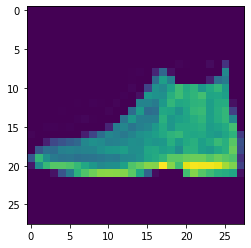

GT-class:  Ankle boot
NN on org Image  ('Ankle boot', 0.92717516)
CNN on org Image  ('Ankle boot', 0.99849355)


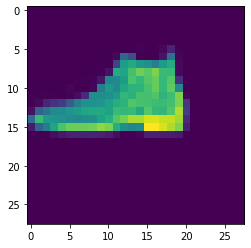

NN on transform Image  ('Sneaker', 0.9835293)
CNN on transform Image  ('Sneaker', 0.9943856)

**************************************************************



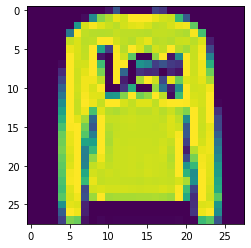

GT-class:  Pullover
NN on org Image  ('Pullover', 0.9962351)
CNN on org Image  ('Pullover', 0.9986266)


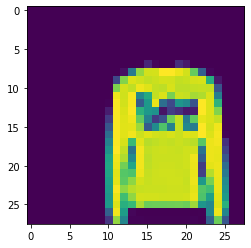

NN on transform Image  ('Sneaker', 0.6212159)
CNN on transform Image  ('Pullover', 0.4253209)

**************************************************************



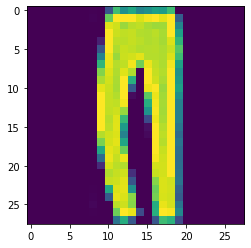

GT-class:  Trouser
NN on org Image  ('Trouser', 1.0)
CNN on org Image  ('Trouser', 0.9999999)


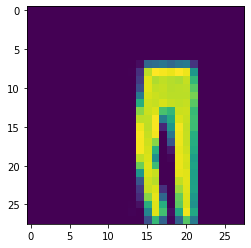

NN on transform Image  ('Sneaker', 0.9707802)
CNN on transform Image  ('Trouser', 0.9985115)

**************************************************************



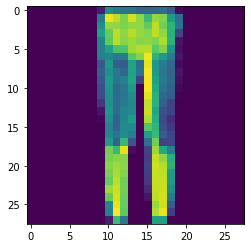

GT-class:  Trouser
NN on org Image  ('Trouser', 1.0)
CNN on org Image  ('Trouser', 0.9999901)


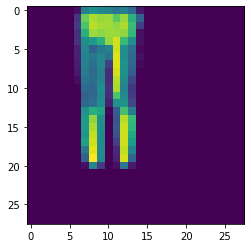

NN on transform Image  ('Dress', 0.57158387)
CNN on transform Image  ('Dress', 0.4412409)

**************************************************************



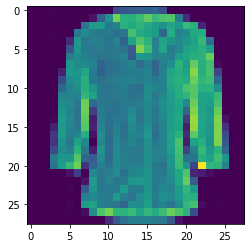

GT-class:  Shirt
NN on org Image  ('Shirt', 0.8316835)
CNN on org Image  ('Shirt', 0.54866123)


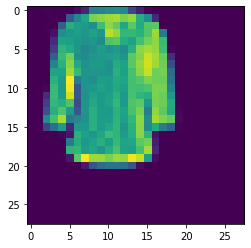

NN on transform Image  ('T-shirt/top', 0.53712153)
CNN on transform Image  ('Shirt', 0.5870681)

**************************************************************



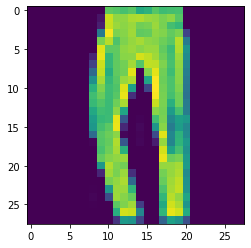

GT-class:  Trouser
NN on org Image  ('Trouser', 1.0)
CNN on org Image  ('Trouser', 1.0)


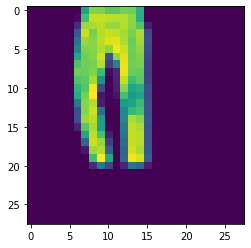

NN on transform Image  ('Dress', 0.5295254)
CNN on transform Image  ('Trouser', 0.63347477)

**************************************************************



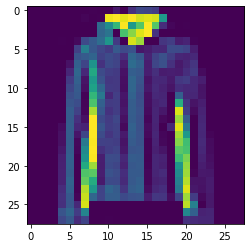

GT-class:  Coat
NN on org Image  ('Coat', 0.99898726)
CNN on org Image  ('Coat', 0.96576124)


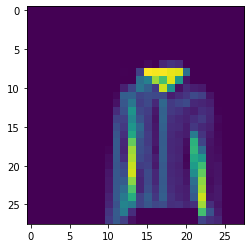

NN on transform Image  ('Sandal', 0.9265774)
CNN on transform Image  ('Coat', 0.86197454)

**************************************************************



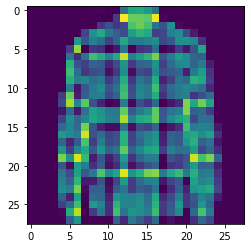

GT-class:  Shirt
NN on org Image  ('Shirt', 0.9868154)
CNN on org Image  ('Shirt', 0.9873017)


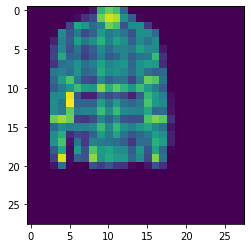

NN on transform Image  ('T-shirt/top', 0.54988337)
CNN on transform Image  ('Shirt', 0.9591556)

**************************************************************



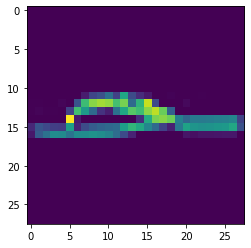

GT-class:  Sandal
NN on org Image  ('Sandal', 1.0)
CNN on org Image  ('Sandal', 0.9999999)


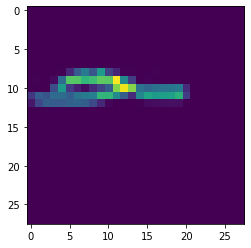

NN on transform Image  ('T-shirt/top', 0.9860945)
CNN on transform Image  ('Sandal', 0.99951756)

**************************************************************



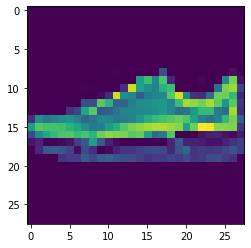

GT-class:  Sneaker
NN on org Image  ('Sneaker', 0.9999863)
CNN on org Image  ('Sneaker', 0.99997044)


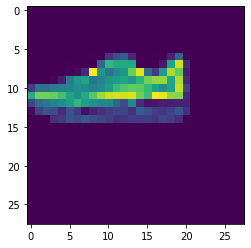

NN on transform Image  ('T-shirt/top', 0.9800597)
CNN on transform Image  ('Sneaker', 0.9969013)

**************************************************************



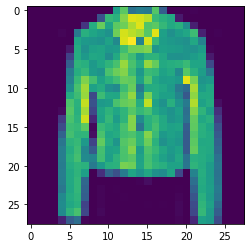

GT-class:  Coat
NN on org Image  ('Coat', 0.9416152)
CNN on org Image  ('Coat', 0.9795069)


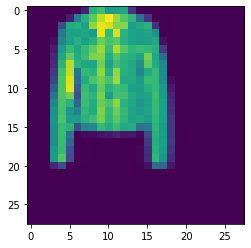

NN on transform Image  ('T-shirt/top', 0.76984674)
CNN on transform Image  ('Shirt', 0.9119415)

**************************************************************



In [ ]:
for i in range(len(test_images)):
  
  img = test_images[i]
  img_nn, img_cnn = preprocess_img(img)
  plt.imshow(img)
  plt.show()
  print('GT-class: ', classes[test_labels[i]])
  print('NN on org Image ', predict(nn_model, img_nn))
  print('CNN on org Image ', predict(cnn_model, img_cnn))
  
  img_nn, img_cnn = translate_object(img)

  predict(nn_model, img_nn)
  predict(cnn_model, img_cnn)
  print('NN on transform Image ', predict(nn_model, img_nn))
  print('CNN on transform Image ', predict(cnn_model, img_cnn))

  print('\n**************************************************************\n')
  if(i == 10):
    break
  #break